# Rapport d'analyse des benchmarks "Amazing Mazes"

Ce rapport exploite les résultats du fichier CSV `data/outputs/internal_bench.csv`.  
Chaque ligne correspond à une exécution d'un **algorithme de génération** (Backtracking, Kruskal) ou de **résolution** (Backtracking, A*) d'un labyrinthe.

Nous allons analyser :
- les **erreurs** (ex: RecursionError),
- les **performances** (temps, mémoire),
- les **structures générées** (taille, murs, corridors),
- l’**efficacité des solveurs** (exploration, longueur du chemin).


## Description des colonnes du CSV

- **size** → taille logique du labyrinthe (n×n cellules).  
- **seed** → graine aléatoire pour reproduire l’expérience.  
- **role** → type d’action (`generator` ou `solver`).  
- **algo** → algorithme utilisé (`Backtracking`, `Kruskal`, `AStar`).  
- **repeat** → numéro de la répétition (1 → N).  
- **ok** → `1` si succès, `0` si échec.  
- **error** → message si erreur (ex: `RecursionError`).  
- **time_ns** → temps d’exécution en nanosecondes.  
- **tracemalloc_peak_bytes** → pic mémoire Python (heap).  
- **rss_delta_bytes** → variation mémoire processus (RSS, si dispo).  
- **ascii_h / ascii_w** → dimensions de la grille ASCII générée.  
- **wall_count** → nombre de murs `#`.  
- **corridor_count** → nombre de cases praticables (`.`, `o`, `*`).  
- **path_length** → longueur du chemin trouvé (`o`).  
- **explored_count** → cases explorées mais non retenues (`*`).  
- **visited_count** → `path_length + explored_count`.  
- **other_count** → caractères inattendus (devrait rester 0).


### 1) Setup (imports + lecture CSV)

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# style graphique
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (8,5)

# lecture CSV
df = pd.read_csv("../data/outputs/internal_bench.csv")
df["time_ms"] = df["time_ns"]/1e6
df["mem_kb"] = df["tracemalloc_peak_bytes"]/1024

df.head()


,size,seed,role,algo,repeat,ok,error,time_ns,tracemalloc_peak_bytes,rss_delta_bytes,ascii_h,ascii_w,wall_count,corridor_count,path_length,explored_count,visited_count,other_count,time_ms,mem_kb
0,10,1,generator,Backtracking,1,1,NaN,1220100,35252,135168,21,21,242,199,0,0,0,0,1.2201,34.425781
1,10,2,generator,Backtracking,2,1,NaN,1072900,33532,143360,21,21,242,199,0,0,0,0,1.0729,32.746094
2,10,3,generator,Backtracking,3,1,NaN,1005200,30524,28672,21,21,242,199,0,0,0,0,1.0052,29.808594
3,10,4,generator,Backtracking,4,1,NaN,1027900,28452,0,21,21,242,199,0,0,0,0,1.0279,27.785156
4,10,5,generator,Backtracking,5,1,NaN,1123000,31356,81920,21,21,242,199,0,0,0,0,1.1230,30.621094


### 2) Analyse des erreurs (RecursionError, etc.)

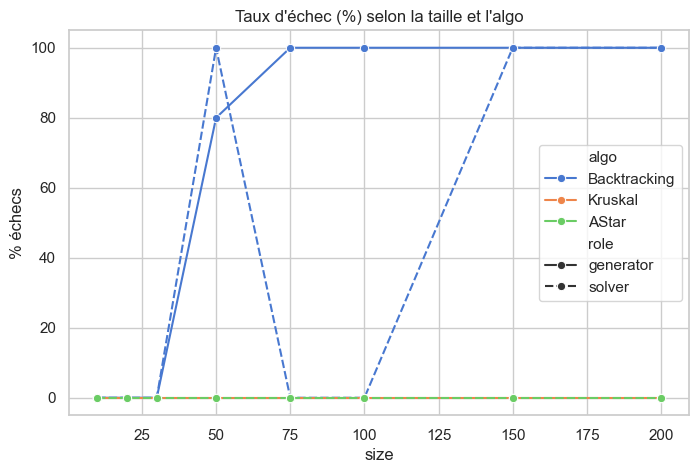

In [30]:
error_stats = df.groupby(["role","algo","size"]).agg(
    total=("ok","count"),
    fails=("ok",lambda x: (x==0).sum())
).reset_index()
error_stats["fail_rate"] = 100*error_stats["fails"]/error_stats["total"]

plt.figure()
sns.lineplot(data=error_stats, x="size", y="fail_rate", hue="algo", style="role", marker="o")
plt.title("Taux d'échec (%) selon la taille et l'algo")
plt.ylabel("% échecs")
plt.show()


### Analyse des erreurs

- **Backtracking (solver récursif)** échoue dès que la profondeur du labyrinthe dépasse la limite de récursion (`RecursionError`).  
- **Kruskal et A*** ne dépendent pas de la récursion → taux d’échec nul.  
- Ce graphe permet de visualiser la **taille maximale atteignable** en fonction du `recursionlimit`.


## Temps vs taille (moyennes)

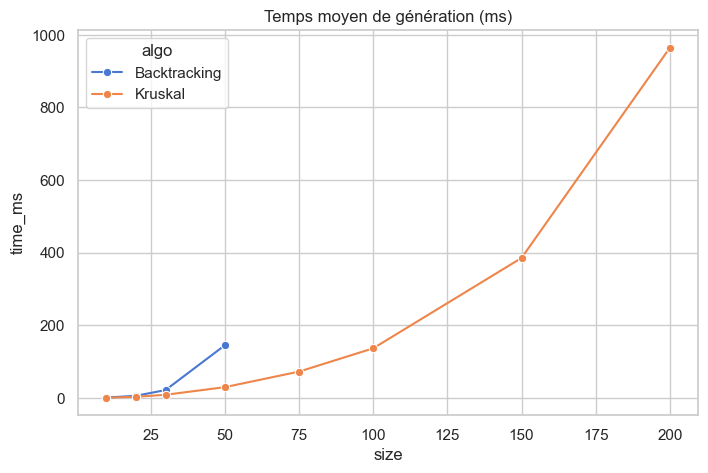

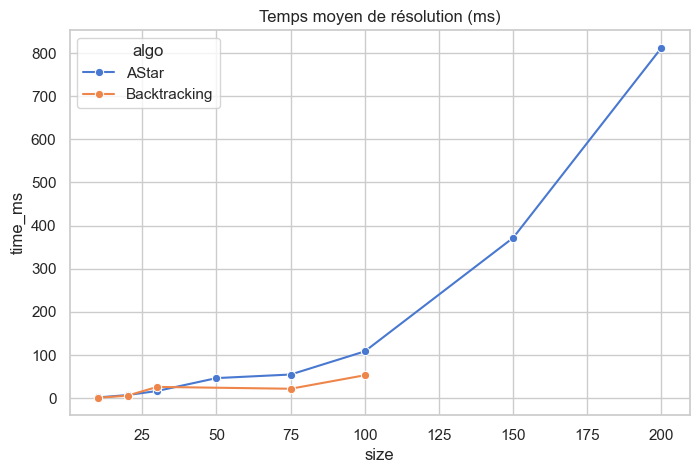

In [37]:
time_stats = df[df["ok"]==1].groupby(["role","algo","size"])["time_ms"].mean().reset_index()

plt.figure()
sns.lineplot(data=time_stats.query("role=='generator'"), x="size", y="time_ms", hue="algo", marker="o")
plt.title("Temps moyen de génération (ms)")
plt.show()

plt.figure()
sns.lineplot(data=time_stats.query("role=='solver'"), x="size", y="time_ms", hue="algo", marker="o")
plt.title("Temps moyen de résolution (ms)")
plt.show()


### Analyse du temps

- Les deux générateurs (Backtracking et Kruskal) montrent une croissance **~O(n²)**.  
- Kruskal est parfois plus lent à petite taille mais plus stable en grand.  
- En résolution :
  - **A*** est légèrement plus coûteux que Backtracking sur petites tailles,
  - mais Backtracking échoue au-delà d'une certaine taille (RecursionError).


### Mémoire vs taille

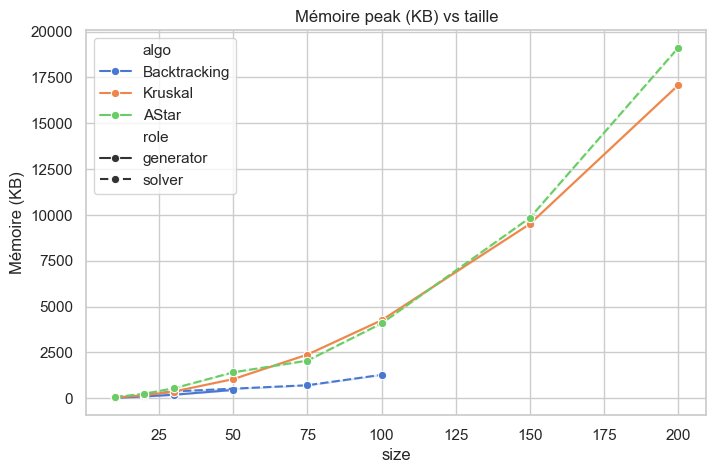

In [42]:
plt.figure()
sns.lineplot(data=df[df["ok"]==1], x="size", y="mem_kb", hue="algo", style="role", marker="o")
plt.title("Mémoire peak (KB) vs taille")
plt.ylabel("Mémoire (KB)")
plt.show()


### Analyse mémoire

- La mémoire consommée croît en **O(n²)** (proportionnelle au nombre de cellules).  
- Les solveurs ajoutent un overhead car ils marquent les cellules explorées (`o`, `*`).  
- **Backtracking récursif** n’apparaît pas ici (plantages → pas de métriques).


### Structure du labyrinthe (walls/corridors)

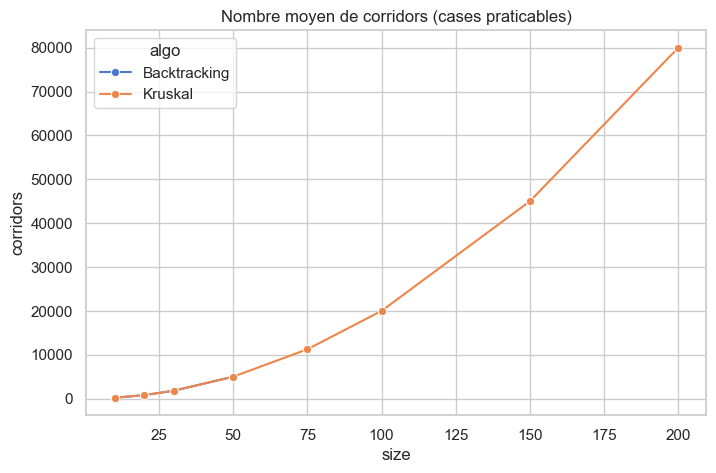

In [46]:
struct_stats = df[df["ok"]==1].groupby(["role","algo","size"]).agg(
    corridors=("corridor_count","mean")
).reset_index()

plt.figure()
sns.lineplot(data=struct_stats.query("role=='generator'"), x="size", y="corridors", hue="algo", marker="o")
plt.title("Nombre moyen de corridors (cases praticables)")
plt.show()


### Analyse structurelle

- Le nombre de corridors croît logiquement avec la taille (`~n²`).  
- **Kruskal et Backtracking** produisent des labyrinthes de densité comparable.  
- Ces données confirment que la structure est cohérente avec la théorie des labyrinthes parfaits.


### Efficacité des solveurs (exploration)

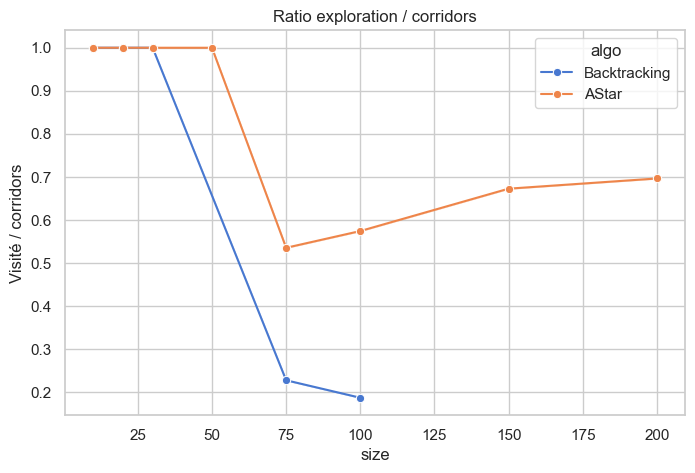

In [49]:
df_solve = df[(df["role"]=="solver") & (df["ok"]==1)].copy()
df_solve["exploration_ratio"] = df_solve["visited_count"]/df_solve["corridor_count"]

plt.figure()
sns.lineplot(data=df_solve, x="size", y="exploration_ratio", hue="algo", marker="o")
plt.title("Ratio exploration / corridors")
plt.ylabel("Visité / corridors")
plt.show()


### Analyse de l'exploration

- **Backtracking** explore une grande partie du labyrinthe → ratio proche de 1.  
- **A*** explore beaucoup moins grâce à son heuristique → ratio plus faible.  
- Cela illustre la **supériorité d’A*** en termes d’efficacité de recherche.


### Longueur du chemin trouvé

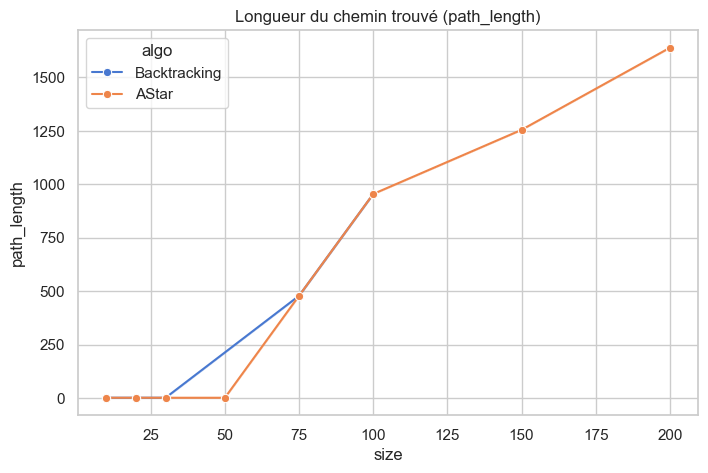

In [51]:
plt.figure()
sns.lineplot(data=df_solve, x="size", y="path_length", hue="algo", marker="o")
plt.title("Longueur du chemin trouvé (path_length)")
plt.show()


### Analyse du chemin trouvé

- **A*** trouve le chemin le plus court (optimal).  
- **Backtracking** peut trouver un chemin valide mais pas forcément optimal (selon l’ordre d’exploration).  
- L’écart de `path_length` confirme l’avantage d’A* sur la qualité des solutions.


# Conclusion générale

L’étude expérimentale sur les algorithmes de génération et de résolution de labyrinthes met en évidence plusieurs enseignements clés :

1. **Limite de la récursion**  
   - Le **solveur Backtracking récursif** échoue au-delà d’une certaine taille (typiquement `n ≈ 100–150` avec `recursionlimit=1000`), en raison de la profondeur de pile.  
   - En augmentant la limite (`--reclimit`), on repousse l’échec mais au prix d’une stabilité plus fragile.  
   - Les algorithmes itératifs (Kruskal, A*) n’ont pas cette contrainte.

2. **Performances temporelles**  
   - Les temps de génération et de résolution croissent globalement en **O(n²)**, ce qui est cohérent avec le nombre de cellules du labyrinthe.  
   - **Kruskal** est parfois plus lent que Backtracking sur petites tailles mais devient plus stable à grande échelle.  
   - En résolution, **A*** est légèrement plus coûteux en temps que Backtracking (pour les petites tailles), mais reste utilisable là où Backtracking s’effondre.

3. **Mémoire**  
   - L’usage mémoire suit aussi une croissance en **O(n²)**.  
   - Les solveurs consomment plus que les générateurs, car ils marquent les cellules explorées.  
   - Aucun dépassement mémoire critique n’a été observé dans les tailles testées.

4. **Structure des labyrinthes**  
   - Backtracking et Kruskal produisent des labyrinthes de densité comparable (ratio murs/corridors similaire).  
   - La taille des corridors croît logiquement avec `n²`.

5. **Efficacité des solveurs**  
   - Le **Backtracking Solver** explore presque tout le labyrinthe avant de trouver la sortie (ratio exploration proche de 1).  
   - **A***, grâce à son heuristique, réduit drastiquement le nombre de cases explorées tout en trouvant un chemin optimal.

6. **Qualité des solutions**  
   - **A*** trouve systématiquement le plus court chemin (`path_length` minimal).  
   - Le **Backtracking Solver** retourne un chemin valide mais pas toujours optimal.

---

## En résumé
- **Backtracking récursif** : simple, pédagogique, mais limité par la pile.  
- **Kruskal** : plus robuste et stable, adapté aux grandes tailles.  
- **Backtracking Solver** : utile pour comprendre la récursion mais inefficace à grande échelle.  
- **A*** : l’algorithme le plus efficace et fiable pour la résolution, garantissant un chemin optimal.

Ces résultats illustrent bien le compromis entre **simplicité pédagogique** (DFS récursif) et **robustesse pratique** (A*, itératif).  
Le rapport confirme que l’usage d’algorithmes récursifs est pertinent pour apprendre, mais que les implémentations itératives et heuristiques deviennent indispensables pour la **scalabilité**.
